In [1]:
using Pkg, Revise
gla_dir = "../GenLinAlgProblems"
Pkg.activate(gla_dir)
# alternatively, cd into GenLinAlgProblems, start julia, and add the package to dev:   pkg> dev .
using GenLinAlgProblems, LinearAlgebra, RowEchelon, LaTeXStrings, Latexify, SymPy, Random

using PyCall
itikz = pyimport("itikz")
nM    = pyimport("itikz.nicematrix");

  Activating project at `C:\Users\Edgar Auger\NOTEBOOKS\elementary-linear-algebra\GenLinAlgProblems`


<div style="float:center;width:100%;text-align:center;">
<strong style="height:15px;color:darkred;font-size:40pt;">Givens Rotations</strong>
</div>

<div>
<div style="float:left;width:30%;"><img src="./Figs/GivensRotation.svg" width=300></div>
<div style="float:right;padding-left:2cm;padding-top:1cm;width:60%;">

**Idea:** Rotate a vector onto an elementary basis vector to introduce a zero value.

$\qquad$ Given the vector $v = \begin{pmatrix} a \\ b \end{pmatrix}$, rotate it onto $\tilde{v} = \begin{pmatrix} r \\ 0 \end{pmatrix}$
where $r = \sqrt{a^2 + b^2}$.

The **rotation matrix** is given by<br><br>

$\qquad
R = \frac{1}{r} \left( \begin{array}{rr} a & b \\ -b & a \end{array} \right)
$<br><br>
    
**Remark:** the rotation matrix $R$ is **orthogonal,** $\quad$ i.e., $R^{-1} = R^t$
</div>
</div>

# 1. Givens Rotation Algorithm

Introduce zero values in a given column by applying a rotation to each non-zero element below the pivot position.<br>
$\qquad$ for value $a$ in row $i$, and value $b$ in row $j$, the elimination matrix $G$ has the form

$$
G = \left(\begin{array}{rrrrr}
                    I &  \color{red}0 & 0 & \color{red}0 & 0 \\
                    \color{red}0 &  \color{blue}{\mathbf{c}} & \color{red}0 & \color{blue}{\mathbf{s}} & \color{red}0 \\
                    0 &  \color{red}0 & I & \color{red}0 & 0 \\
                    \color{red}0 & \color{blue}{\mathbf{-s}} & \color{red}0 & \color{blue}{\mathbf{c}} & \color{red}0 \\
                    0 &  \color{red}0 & 0 & \color{red}0 & I \\
\end{array}\right)
$$

where $c = cos\ \theta = \frac{a}{r},\; s = sin\ \theta = \frac{b}{r},$ and rows and columns $i$ and $j$ of $G$ are shown in red and blue.

$\qquad$ We augment the matrix $A$ by $I$ to capture the overall elimination matrix applied.

In [79]:
function naive_givens(A)
    e   = eltype(A)
    m,n = size(A)
    AI  = [copy(A) one(e)I(m)]

    matrices = [ [:none, AI ] ]
    desc     = []
    
    i = 1; j = 1
    while i < m && j <= n
        did_a_rotation = 0
        for k = i+1:m                          # zero out each entry below current pivot position (i,j)
            if AI[k,j] != zero(e)
                x = [ AI[i,j]; AI[k,j] ]       # vector (a,b)
                r  = sqrt(x[1]^2 + x[2]^2 )
                c  = x[1]/r
                s  = x[2]/r

                G  = Matrix(one(e)I(m))        # rotation matrix
                G[i,i] =  c; G[i, k] = s
                G[k,i] = -s; G[k, k] = c

                AI = copy(AI)
                AI = G * AI
                did_a_rotation = 1
                push!( matrices, [G, copy(AI)])
                push!(desc, [i-1,k-1,j-1])
            end
        end
        i = i+did_a_rotation   # next row if we found a pivot, else current row
        j = j+1                # next column
    end
    matrices, desc
end;

In [80]:
function decorate_givens( desc )
    bg = []
    for lvl=1:length(desc)
        i,k,j = desc[lvl]
        push!(bg, [lvl,   0, [(i,i), (i,k), (k,i), (k,k)], "yellow!50"] )
        push!(bg, [lvl,   1, [(i, j), (k, j)], "yellow!50"] )
        push!(bg, [lvl-1, 1, [(i, j), (k, j)], "red!15"] )
    end
    bg
end;

## 1.1 Small Example with Rationals

In [90]:
Random.seed!(16242)
function nice_A(m,n,r; maxint=3)
    Q = Q_matrix(m)
    R,_ = ref_matrix(m,n,r; maxint=maxint)
    SymPy.Sym.(Q*R)
end
A=nice_A(4,4,2);
latexify(A)

L"\begin{equation}
\left[
\begin{array}{cccc}
\frac{-36}{35} & 0 & \frac{-12}{35} & \frac{144}{35} \\
\frac{-6}{7} & 0 & \frac{12}{7} & \frac{-18}{7} \\
\frac{27}{35} & 0 & \frac{9}{35} & \frac{-108}{35} \\
\frac{-18}{7} & 0 & \frac{22}{7} & \frac{-12}{7} \\
\end{array}
\right]
\end{equation}
"

In [82]:
matrices, desc = naive_givens(A)
R              = matrices[end][2][:,1:size(A,2)]
Q              = matrices[end][2][:,size(A,2)+1:end]'
;
#println(desc);

In [84]:
println( "A ≈ Q R    is  $(A ≈ Q*R)\n" )
latexify([Q',R']')

A ≈ Q R    is  true



L"\begin{equation}
\left[
\begin{array}{cc}
\left[
\begin{array}{cccc}
\frac{-12}{35} & \frac{-24}{35} & \frac{-3}{5} & \frac{-8}{35} \\
\frac{-2}{7} & \frac{3}{7} & 0 & \frac{-6}{7} \\
\frac{9}{35} & \frac{18}{35} & \frac{-4}{5} & \frac{6}{35} \\
\frac{-6}{7} & \frac{2}{7} & 0 & \frac{3}{7} \\
\end{array}
\right] & \left[
\begin{array}{cccc}
3 & 0 & -3 & 0 \\
0 & 0 & 2 & -6 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{array}
\right] \\
\end{array}
\right]
\end{equation}
"

Reverting Windows console CPs to (in,out) = (437,437)


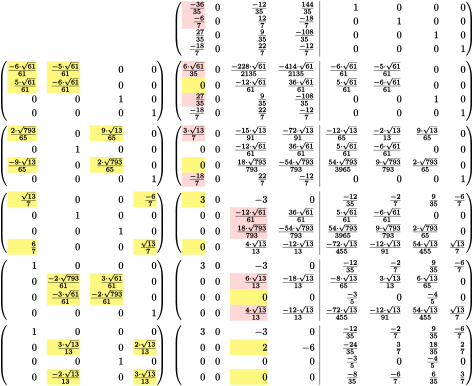

In [63]:
h,_= nM.ge( to_latex(matrices), formater=x->x, Nrhs=size(A,1),
    bg_for_entries=decorate_givens(desc),
    tmp_dir="/tmp")
h

## 1.2 Floating Point Example

In [87]:
Random.seed!(14225)
A             = Float64.(nice_A(5,4,3; maxint=3))
matrices,desc = naive_givens(A)
R             = matrices[end][2][:,1:size(A,2)]
Q             = matrices[end][2][:,size(A,2)+1:end]'
;
#println.(desc);

In [86]:
println( "A ≈ Q R    is  $(A ≈ Q*R)" )

A ≈ Q R    is  true


Reverting Windows console CPs to (in,out) = (437,437)


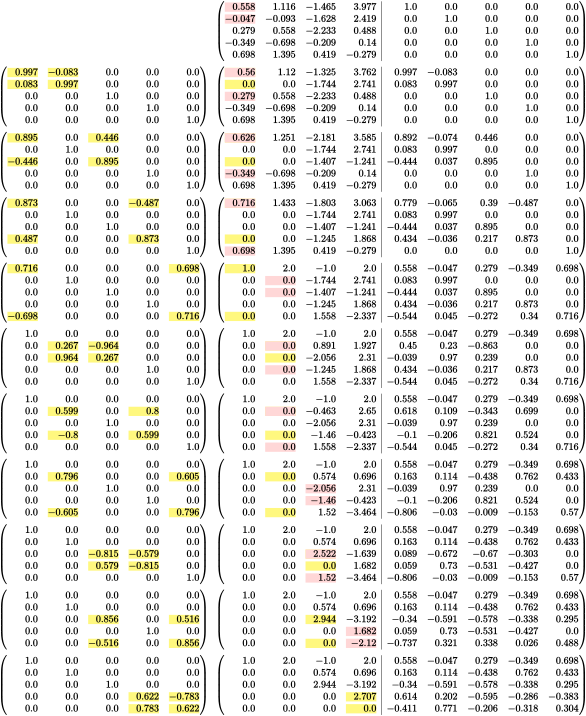

In [78]:
h,m=nM.ge( round_matrices( matrices,3), Nrhs=size(A,1),
    bg_for_entries=decorate_givens(desc),
    tmp_dir="/tmp")
h

**Remark:** The apparent computation using 0 entries is due rounding to 3 digits.


## 1.3 Remark: this is a QR Decomposition

In [88]:
Q'Q ≈ I

true

In [89]:
Q'Q

5×5 Matrix{Float64}:
  1.0          1.07595e-16  -1.42594e-17  -5.06923e-17   8.85637e-18
  1.07595e-16  1.0           1.3448e-16    1.03445e-16   1.62086e-16
 -1.42594e-17  1.3448e-16    1.0          -3.16327e-17  -5.33802e-17
 -5.06923e-17  1.03445e-16  -3.16327e-17   1.0          -6.66777e-17
  8.85637e-18  1.62086e-16  -5.33802e-17  -6.66777e-17   1.0